# Generate Random Networks Based on Delaunay Triangulations,  Voronoi Tessellations, or Both

A random network offers several advantages over the traditional Cubic arrangement: the topology is more 'natural' looking, and a wider pore size distribution can be achieved since pores are not constrained by the lattice spacing.  Random networks can be tricky to generate however, since the connectivity between pores is difficult to determine or define.  One surprisingly simple option is to use Delaunay triangulation to connect base points (which become pore centers) that are randomly distributed in space.  The Voronoi tessellation is a complementary graph that arises directly from the Delaunay graph which also connects essentially randomly distributed points in space into a network.  OpenPNM offers both of these types of network, plus the ability to create a network containing *both* including interconnections between Delaunay and Voronoi networks via the ```DelaunayVoronoiDual``` class.  In fact, creating the dual, interconnected network is the starting point, and any unwanted elements can be easily trimmed.

In [1]:
import openpnm as op
import matplotlib.pyplot as plt

In [2]:
# NBVAL_IGNORE_OUTPUT
pn = op.network.DelaunayVoronoiDual(num_points=100, shape=[1, 1, 1])
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.DelaunayVoronoiDual : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     787 / 787  
2     throat.conns                                   4418 / 4418 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      787       
2     pore.back                                     65        
3     pore.bottom                                   56        
4     pore.boundary                                 333       
5     pore.delaunay                     

The above line of code is deceptively simple.  The returned network (```pn```) contains a fully connected Delaunay network, its complementary Voronoi network, and interconnecting throats (or bonds) between each Delaunay pore (node) and its neighboring Voronoi pores.  Such a highly complex network would be useful for modeling pore phase transport (i.e. diffusion) on one network (i.e. Delaunay), solid phase transport (i.e. heat transfer) on the other network (i.e. Voronoi), and exchange of a species (i.e. heat) between the solid and void phases via the interconnecting bonds.  Each pore and throat is labelled accordingly (i.e. 'pore.delaunay', 'throat.voronoi'), and the interconnecting throats are labelled 'throat.interconnect'.  Moreover, pores and throats lying on the surface of the network are labelled 'surface'.  

A quick visualization of this network can be accomplished using OpenPNM's built-in graphing tool.  The following shows only the Voronoi connections that lie on the surface of the cube:

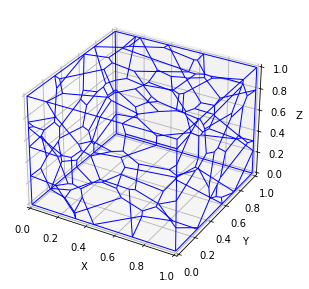

In [3]:
# NBVAL_IGNORE_OUTPUT
Ts = pn.throats(['voronoi', 'boundary'], mode='and')
op.topotools.plot_connections(network=pn, throats=Ts)

One central feature of these networks are the flat boundaries, which are essential when performing transport calculations since they provide well-defined control surfaces for calculating flux.  This flat surfaces are accomplished by reflecting the base points across each face prior to performing the tessellations.  

Plotting the internal Voronoi throats with a different color gives a good idea of the topology:

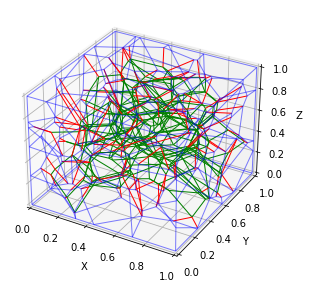

In [4]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots()
Ts = pn.throats(['voronoi', 'boundary'], mode='and')
op.topotools.plot_connections(network=pn, throats=Ts, alpha=0.5, ax=ax)
Ts = pn.throats(['voronoi', 'internal'], mode='and')
op.topotools.plot_connections(network=pn, throats=Ts, c='g', ax=ax)
Ts = pn.throats(['voronoi', 'surface'], mode='and')
op.topotools.plot_connections(network=pn, throats=Ts, c='r', ax=ax)

The green lines are internal connections, and red lines are connections between internal notes and boundary nodes. 

## Delaunay Network

As the name suggests, the VoronoiDelaunayDual contains both the Delaunay triangulation and the Voronoi tessellation within the same topology. It is simple to delete one network (or the other) by trimming all of the other network's pores, which also removes all connected throats including the interconnections:

In [5]:
# NBVAL_IGNORE_OUTPUT
Ps = pn.pores(['voronoi'])
op.topotools.trim(network=pn, pores=Ps)
Ts = pn.throats(['surface'])
op.topotools.trim(network=pn, throats=Ts)

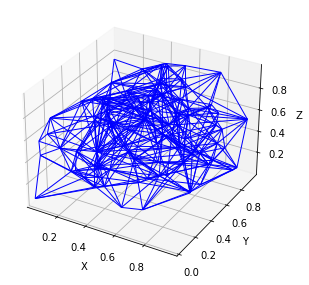

In [6]:
op.topotools.plot_connections(network=pn)

## Create Random Networks of Spherical or Cylindrical Shape

Many porous materials come in spherical or cylindrical shapes, such as catalyst pellets.  The ```DelaunayVoronoiDual``` Network class can produce these geometries by specifying the ```domain_size``` in cylindrical [r, z] or spherical [r] coordinates:

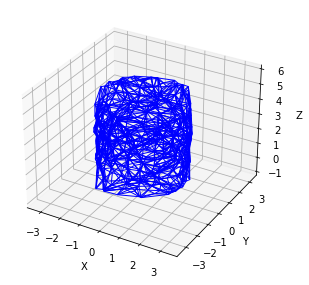

In [7]:
# NBVAL_IGNORE_OUTPUT
cyl = op.network.DelaunayVoronoiDual(num_points=200, shape=[2, 5])
op.topotools.plot_connections(network = cyl, throats=cyl.throats('boundary'))

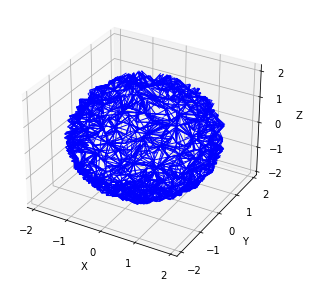

In [8]:
# NBVAL_IGNORE_OUTPUT
sph = op.network.DelaunayVoronoiDual(num_points=500, shape=[2])
op.topotools.plot_connections(network = sph, throats=sph.throats('surface'))

Note that the cylindrical and spherical networks don't look very nice when too few points are used, so at least about 200 is recommended.  

## Assign Pore Sizes to the Random Network

With pore centers randomly distributed in space it becomes challenging to know what pore size to assign to each location.  Assigning pores that are too large results in overlaps, which makes it impossible to properly account for porosity and transport lengths.  OpenPNM includes a Geometry model called ```largest_sphere``` that solves this problem.  Let's assign the largest possible pore size to each Voronoi node in the ```sph``` network just created:

In [9]:
Ps = sph.pores('voronoi')
Ts = sph.throats('voronoi')
geom = op.geometry.GenericGeometry(network=sph, pores=Ps, throats=Ts)

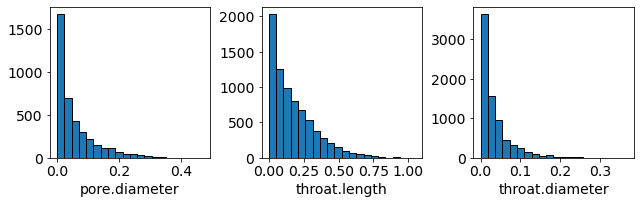

In [10]:
# NBVAL_IGNORE_OUTPUT
mod = op.models.geometry.pore_size.largest_sphere
geom.add_model(propname='pore.diameter', model=mod)
mod = op.models.geometry.throat_length.ctc
geom.add_model(propname='throat.length', model=mod)
mod = op.models.geometry.throat_size.from_neighbor_pores
geom.add_model(propname='throat.diameter', model=mod)
geom.show_hist(['pore.diameter', 'throat.length', 'throat.diameter'])

The resulting geometrical properties can be viewed with ```geom.plot_histograms()``` (note that each realization will differ slightly):